In [1]:
import time
start_time = time.time()
import cyipopt
import math
import matplotlib.pyplot as plt
import numpy as np
from cyipopt import minimize_ipopt
from phe import paillier
%matplotlib widget

end_time = time.time()
total_runtime = end_time - start_time
print("Total time required to import Modules = %f seconds " % total_runtime)

Total time required to import Modules = 0.715211 seconds 


# Encrypted Lyapunov Economic Model Predictive Control(LEMPC) of a Continuous Stirred Tank Reactor(CSTR)

In this code, we will apply Encrypted LEMPC to a CSTR to optimize the operation of the system based on our defined Economic model.

Note that in this design, the LEMPC is solved in the unencrypted space, but all signals are transmitted as encrypted signals, and decrpyted only when non-linear computation is needed.

## Encryption

Before encrypting a value, we first need to map it to the following quantized set:
\begin{align*}
\mathbb{Q}_{l_1,d}=\{x\in\mathbb{Q}\vert{}-2^{l_1-d-1}\leq{x}\leq{}2^{l_1-d-1}-2^{-d},\exists{k}\in\mathbb{Z}:x=k\times2^{-d}\}
\end{align*}

This is done via a function: 
\begin{align*}
g_{l_1,d}&:\mathbb{R}\rightarrow\mathbb{Q}_{l_1,d} \\
g_{l_1,d}(a)&:=\arg\min_{q\in{\mathbb{Q}_{l_1,d}}}\lvert{a-q}\rvert
\end{align*}

The Pallier Encryption Scheme only applies to $x\in\mathbb{Z}_n$ where $2^{n_{length}-1}\leq{n}<2^{n_{length}}-1$, with a function:
\begin{align*}
f_{l_2,d}&:\mathbb{Q}_{l_1,d}\rightarrow\mathbb{Z}_{2^{l_2}} \\
f_{l_2,d}(q)&:=2^dq{\bmod{}}2^{l_2}
\end{align*}

Because we define the key-length to be `n_length=128`, we say that $0\leq{x}\leq{2^{l_2}}<n$, i.e. $l_1\leq{l_2}<2^{n_{length}-1}$

Thus, we can simply say $l_2=l_1$, but we must ensure that $l_1<n_{length}$

Because of how the modulus operation works on negative numbers, and because we include 0 but exclude the upper bound while including the lower bound in our quantized set, all negative values will be at or above the median element of this set. Thus, we can invert the bijective mapping via:
\begin{align*}
f_{l_2,d}^{-1}&:\mathbb{Z}_{2^{l_2}}\rightarrow\mathbb{Q}_{l_1,d} \\
f_{l_2,d}^{-1}(m)&:=\frac{1}{2^d}\begin{cases} m-2^{l_2} & m\geq{2^{l_2-1}} \\ m & \text{otherwise}  \end{cases}
\end{align*}

In [2]:
start_time = time.time()
public_key, private_key = paillier.generate_paillier_keypair(n_length=128)
d1 = 8
l1 = 28
Q_l = -(2 ** (l1 - d1 - 1))
Q_u = 2 ** (l1 - d1 - 1) - 2 ** (-d1)


def quant1(val):
    return np.fmin(np.fmax(np.round(val / (2 ** (-d1))) * (2 ** (-d1)), Q_l), Q_u)


def quant2(val):
    return int((2**d1) * val % (2**l1))


def quant3(val):
    return np.where(
        (val % (2**l1)) >= (2 ** (l1 - 1)), (val % (2**l1)) - (2**l1), (val % (2**l1))
    ) / (2**d1)


end_time = time.time()
total_runtime = end_time - start_time
print(
    "Total time required to initialize Encryption dependencies = %f seconds "
    % total_runtime
)

Total time required to initialize Encryption dependencies = 0.000999 seconds 


![EMPC_Diagram](EMPC_Diagram.png "lol")

In [3]:
start_time = time.time()
######### Simulation time #########################

delta = 1e-3  # hr Sampling Time
hc = 1e-4  # hr Numerical Integration Step Size
tFinal = 1  # hr Total Simulation Time(including multiple runs)

###################################### MPC simulation constants ##############################################

netTimeSteps = int(tFinal / hc)  # Number of calculated steps
integrationTimeSteps = int(delta / hc)  # Number of steps per horizon
controlTimeSteps = 5  # Number of times Sensor data is read
# NUM_MPC_ITERATION    = int(tFinal/(delta*controlTimeSteps)) # Number of times simulation is run
NUM_MPC_ITERATION = int(tFinal / delta)  # Number of times simulation is run

NUM_OUTPUTS = 2  # Model Outputs: x1 x2
NUM_INPUTS = 4  # Model  Inputs: u1 u2 x1 x2
NUM_U = int(NUM_INPUTS - NUM_OUTPUTS)  # Number of control inputs


NUM_MPC_INPUTS = int(NUM_U * controlTimeSteps)  # 1 set of control inputs per Horizon
NUM_MPC_CONSTRAINTS = controlTimeSteps  # Constraints must be satisfied at all points

################### P matrix #############################
# V= xTP(x) "Energy of Sys"

a = 1060
b = 22
d = 0.52

###########Q Matrices for Cost Function##############
# Qx=np.diag(np.tile([2e3, 1], int(NUM_OUTPUTS/2)))
# Qu=np.diag(np.tile([8e-13, 0.001], int(NUM_OUTPUTS/2)))
A1 = np.array([1, 0.99, 1.01, 0.98, 1.02])
A2 = np.array([17, 14, 5, 7, 9])
A3 = np.array([1e-8, 0.8 * 1e-8, 0.84 * 1e-8, 0.9 * 1e-8, 0.92e-8])

#################### PI Controler Weights ###########
proportionalGainConcentration = 10
proportionalGainHeat = 10000
integralGain = 0.01

end_time = time.time()
total_runtime = end_time - start_time
print(
    "Total time required to initialize Control Paramters = %f seconds " % total_runtime
)

Total time required to initialize Control Paramters = 0.000000 seconds 


### ODE and parameters

The system model is described by the ordinary differential equation:
\begin{align*}
\dot{C}_A &= \frac{F}{V}(C_{A,0} - C_{A}) - k_0\exp\left(\frac{-E_A}{RT}\right)C_A^2\\
\dot{T} &= \frac{F}{V}(T_0-T)-\frac{\Delta{H}k_0\exp\left(\frac{-E_A}{RT}\right)}{\rho_L{C_P}}C_A^2+\frac{\dot{Q}}{\rho_LC_PV}\\
\end{align*}
For simplicity, we work with deviation variables and thus we subtract the steady state values for these ODEs
\begin{align*}
\dot{C}_{A_s} &= \frac{F}{V}(C_{{A,0}_s} - C_{A_s}) - k_0\exp\left(\frac{-E_A}{RT_s}\right)C_{A_s}^2\\
\dot{T_s} &= \frac{F}{V}(T_{0_s}-T_s)-\frac{\Delta{H}k_0\exp\left(\frac{-E_A}{RT_s}\right)}{\rho_L{C_P}}C_{A_s}^2+\frac{\dot{Q_s}}{\rho_LC_PV}\\
\end{align*}
Which results in our final expressions:
\begin{align*}
\dot{\bar{C}}_A &= \frac{F}{V}(\bar{C}_{A,0} - \bar{C}_{A}) - k_0\exp\left(\frac{-E_A}{R(\bar{T}+T_s)}\right)(\bar{C}_A+C_{A_s})^2 + k_0\exp\left(\frac{-E_A}{RT_s}\right)C_{A_s}^2\\
\dot{\bar{T}} &= \frac{F}{V}(\bar{T}_0-\bar{T})-\frac{\Delta{H}k_0\exp\left(\frac{-E_A}{R(\bar{T}+T_s)}\right)}{\rho_L{C_P}}(\bar{C}_A+C_{A_s})^2+\frac{\Delta{H}k_0\exp\left(\frac{-E_A}{RT_s}\right)}{\rho_L{C_P}}C_{A_s}^2+\frac{\dot{\bar{Q}}}{\rho_LC_PV}\\
\text{State-Variables}&=\begin{cases}
\bar{C}_A &= C_A - C_{A_s} \\
\bar{T} &= T - T_s \\
\end{cases}\\
\text{Control-Variables}&=\begin{cases}
\bar{C}_{A,0} &= C_{A,0} - C_{A_s,0} \\
\bar{Q} &= Q - Q_s \\
\end{cases}\\
\text{Redefined-Constants}&=\begin{cases}
\bar{T}_0 &= T_0 - T_{0,s} \\
\end{cases}\\
\text{Constants}&=\begin{cases}
F &= 5\frac{m^3}{hr} \\
V &= 1m^3 \\
\rho_L &= 1\times{10^3}\frac{kg}{m^3} \\
C_P &= 0.231\frac{kJ}{kg-K} \\
\Delta{H} &= -1.15\times{10^4}\frac{kJ}{kmol} \\
E &= 5\times{10^4}\frac{kJ}{kmol} \\
R &= 8.314\frac{kJ}{kmol-K} \\
k_0 &= 8.46\times{10^6}\frac{m^3}{kmol-hr} \\
T_0 &= 300K \\
T_{0_s} &= 300K \\
C_{A_s} &= 1.954 \frac{kmol}{m^3} \\
T_s &= 401.9K \\
Q_s &= 0 \frac{kJ}{hr} \\
C_{A_s,0} &= 4 \frac{kmol}{m^3} \\
\end{cases}
\end{align*}

All that remains is to define the initial values of the State-Variables in Deviation form, but this is up to the user to decide on values.

In [4]:
start_time = time.time()
##################### initial values and initializations ######################

# Initial Values in Deviation Variable Form
CA_real = 1.5  # kmol/m3
T_real = -60  # K

x_record = np.zeros((NUM_OUTPUTS, NUM_MPC_ITERATION + 1))
x_real = np.array([[CA_real], [T_real]])
x_record[:, [0]] = x_real


u_record = np.zeros((NUM_U, NUM_MPC_ITERATION))
offset_record = []
grad_f_record = []
cost_record = []

V_record = []
CostFun = []
status_record = []

realtime_data = None
cost = 0.0

################################ Parameters ######################

# Flowrate Terms
F = 5  # m^3/hr
V = 1  # m^3

# Thermochemical Properties
rhoe_L = 1e3  # kg/m3
Cp = 0.231  # kJ/kg-K
deltaH = -1.15e4  # kJ/kmol
E = 5e4  # kJ/kmol
R = 8.314  # kJ/kmolK
k0 = 8.46e6  # m3/kmol-h

# Thermal Properties
T0 = 300  # K

###################Simplifications################################
E_over_R = -E / R  # K
Coeff1 = F / V
Coeff2 = (deltaH * k0) / (rhoe_L * Cp)
Coeff3 = V * rhoe_L * Cp
######################## steady state values ########################
# Invariant Parameters
T0s = 300  # K

# State Variables
CAs = 1.954  # kmol/m3
Ts = 401.9  # K

# Control Variables
Qs = 0.0  # kJ/hr
CA0s = 4  # kmol/m3

end_time = time.time()
total_runtime = end_time - start_time
print("Total time required to initialize Model Paramters = %f seconds " % total_runtime)

Total time required to initialize Model Paramters = 0.001000 seconds 


# MPC Constraints
The MPC design is as follows:

\begin{align*}
\min_{C_{A,0},Q}\sum_{k=1}^N&{-k_0C_A(t_k)^2\exp{\frac{-E_A}{RT(t_k)}}} \\
\dot{x}&=f(x)+g*u\\
u_L\leq&{u}\leq{u_U} \\
x(t_0) &= x_Q(t_0) \\
V\leq{90}\forall{t} &\text{ if }x((t_0))\in\Omega_{\rho_{min}}\\
\dot{V}_{MPC}(t_0)\leq\dot{V}_{PI}(t_0) &\text{ if }x((t_0))\in\Omega_{\rho}/\Omega_{\rho_{min}}\\
\end{align*}
where
\begin{align*}
x &= [C_A,T] \\
u &= [C_{A,0},Q] \\
P&=\bigg{[}
\begin{matrix}
a & b \\
b & d \\
\end{matrix}
\bigg{]}\\
V&=x^TPx \\
\dot{V}&=2x*P*f + 2x*P*g*u \\
\end{align*}

In [5]:
start_time = time.time()

def model_makestep(CA,T,CA0,Q):
    for _ in range(integrationTimeSteps):  # Newtons Method x_1 ~ x_0 +hc*dx
            fun_1 = (
                Coeff1 * (CA0 - CA)
                - k0 * math.exp(E_over_R / (T + Ts)) * (CA + CAs) ** 2
                + k0 * math.exp(E_over_R / (Ts)) * (CAs) ** 2
            )
            fun_2 = (
                Coeff1 * (T0 - T0s - T)
                - Coeff2 * math.exp(E_over_R / (T + Ts)) * (CA + CAs) ** 2
                + Coeff2 * math.exp(E_over_R / (Ts)) * (CAs) ** 2
                + (Q) / Coeff3
            )
            CA = CA + hc * fun_1
            T = T + hc * fun_2
    return [CA,T]

def eval_f(u):  # L=xQx+uRu
    offset = 0
    x = x_real
    CA = x.item(0)
    T = x.item(1)
    ##Numerical Integration
    for controlIteration in range(controlTimeSteps):
        CA0 = u.item(NUM_U * controlIteration + 0)
        Q = u.item(NUM_U * controlIteration + 1)
        CA,T = model_makestep(CA,T,CA0,Q)
        offset -=  k0 * math.exp(E_over_R / (T + Ts)) * (CA + CAs) ** 2# Sum the Cost at every future sampling time
    return offset * delta


def eval_grad_f(u):  # Finite difference approximation of df/du
    assert len(u) == int(NUM_MPC_INPUTS)
    step = 1.0e-3  # we just have a small step
    objp = objm = 0
    grad_f = [0] * NUM_MPC_INPUTS
    upstep = [0] * NUM_MPC_INPUTS
    umstep = [0] * NUM_MPC_INPUTS
    for i_mpc_input in range(NUM_MPC_INPUTS):
        upstep = u.copy()
        umstep = u.copy()
        upstep[i_mpc_input] = upstep[i_mpc_input] + step
        umstep[i_mpc_input] = umstep[i_mpc_input] - step
        objp = eval_f(
            upstep
        )  # Returns the value of the objective function evaluated when the variable u[i] is perturebed +step
        objm = eval_f(
            umstep
        )  # Returns the value of the objective function evaluated when the variable u[i] is perturebed -step
        grad_f[i_mpc_input] = (objp - objm) / (
            2 * step
        )  # Evaluates the gradient of the objetive function w.r.t the optimization variable x[i]
    grad_f_record.append(grad_f)
    return np.array(grad_f)


def eval_g(u):  # V condition, Vdot condition, the Energy constraint
    g = np.array([1.0] * (controlTimeSteps))  # Default to >0 i.e valid
    x = x_real
    CA = x.item(0)
    T = x.item(1)
    # LfV  = (2 * a * CA + 2 * b * T) * ( Coeff1*(0-CA)-k0*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+k0*np.exp(E_over_R/(Ts))*(CAs)**2 ) + \
    #       (2 * d * T + 2 * b * CA) * ( Coeff1*(T0-T0s-T)-Coeff2*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+Coeff2*np.exp(E_over_R/(Ts))*(CAs)**2+(0)/Coeff3 )
    LfV = 0
    Lg1V = (2 * a * CA + 2 * b * T) * Coeff1
    Lg2V = (2 * d * T + 2 * b * CA) / Coeff3
    dV_op2 = LfV + Lg1V * u.item(0) + Lg2V * u.item(1)  # (EMPC)Vdot = LfV(x)+LgV(x)*u

    kc1 = 2
    kc2 = 12000
    u11 = kc1 * (0 - CA)
    u22 = kc2 * (0 - T)
    dV_Pu2 = LfV + Lg1V * u11 + Lg2V * u22  # (PI)Vdot = LfV(x)+LgV(x)*u

    V_secure = 90
    V_predicted = (a * CA**2) + 2 * (b * CA * T) + (d * T**2)
    if V_predicted <= V_secure:  # If within economic region
        for controlIteration in range(controlTimeSteps):
            CA0 = u.item(NUM_U * controlIteration + 0)
            Q = u.item(NUM_U * controlIteration + 1)
            CA,T = model_makestep(CA,T,CA0,Q)
            g[controlIteration] = V_secure - ((a * CA**2) + 2 * (b * CA * T) + (d * T**2))  # ensure we stay in the economic region
    else:
        g[0] = min(0, dV_Pu2 - 0.000065) - dV_op2  # Difference of MPC and P, Vdot
    return g  # f(x) + C >= 0


# def equalityConstraints(u):  # Material constraint
#     material_used = np.sum(u_record[0])
#     materialUse = 0
#     if main_iteration <= NUM_MPC_ITERATION - controlTimeSteps - 1:
#         for controlIteration in range(controlTimeSteps):
#             material_used = material_used + u.item(NUM_U * controlIteration + 0)
#     else:
#         for controlIteration in range(NUM_MPC_ITERATION - main_iteration):
#             material_used = material_used + u.item(NUM_U * controlIteration + 0)
#     return material_used - materialUse  # f(x) + C= 0


def eval_jac_g(x):
    step = 1e-1  # we just have a small step
    gp = gm = np.zeros(NUM_MPC_CONSTRAINTS)
    xpstep = xmstep = np.zeros(NUM_MPC_INPUTS)
    jac_g = [[0] * int(NUM_MPC_INPUTS) for _ in range(NUM_MPC_CONSTRAINTS)]
    for i_mpc_input in range(NUM_MPC_INPUTS):
        xpstep = x.copy()
        xmstep = x.copy()
        xpstep[i_mpc_input] += step
        xmstep[i_mpc_input] -= step
        gp = eval_g(xpstep)
        gm = eval_g(xmstep)
        for num_constraint in range(NUM_MPC_CONSTRAINTS):
            jac_g[num_constraint][i_mpc_input] = (
                gp[num_constraint] - gm[num_constraint]
            ) / (2 * step)
    return np.array(jac_g)


cons = [
    #{"type": "eq", "fun": equalityConstraints},
    {"type": "ineq", "fun": eval_g, "jac": eval_jac_g},
]
u_L = []
u_U = []
lowerBounds = [-3.5, -5e5]
upperBounds = [3.5, 5e5]
for _ in range(controlTimeSteps):
    u_L = u_L + lowerBounds
    u_U = u_U + upperBounds
bnds = [(u_L[_], u_U[_]) for _ in range(NUM_MPC_INPUTS)]

end_time = time.time()
total_runtime = end_time - start_time
print("Total time required to initialize MPC Constraints = %f seconds " % total_runtime)

Total time required to initialize MPC Constraints = 0.000998 seconds 


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Running Main Code Loop
Number of times IPOPT will be called=  100
Number of Horizons[Sensor Data Readings] =  10
Number of time steps per Horizon =  10
Number of State Variables =  2
Number of Control Inputs =  2
Size of u matrix =  20
Number of MPC Constraints =  10




%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Iteration # 1
Current Un-Quantized State Variable Values: CA =  1.5 , T =  -60.0 K
Current State Variable Values: CA =  1.5 , T =  -60.0 K
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The value of u before optimization is  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Solving IPOPT...
Total time required to solve via IPOPT = 0.090230 seconds 
IPOPT Closed.
 message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
 success: True
  status: 0
     fun: -0.022439433009618006
       x: [-2.261e+00 -1.838e-03 ...  3.911e-05  5.418e-

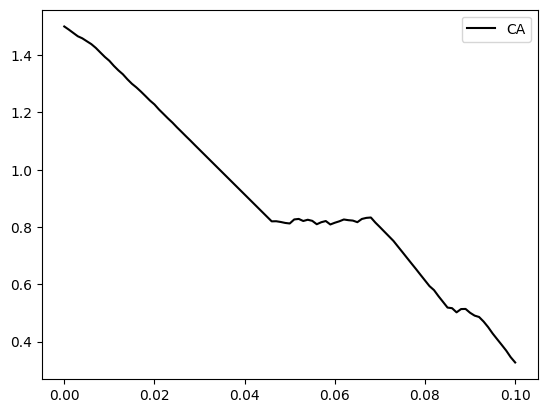

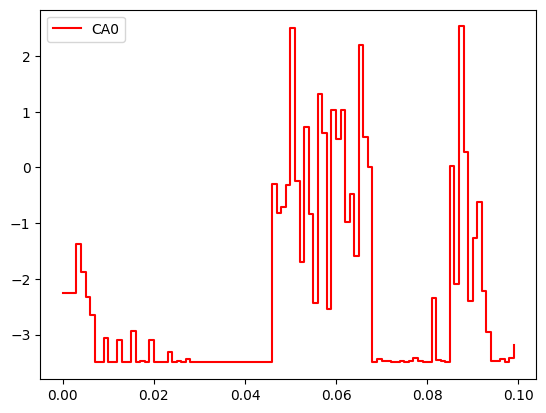

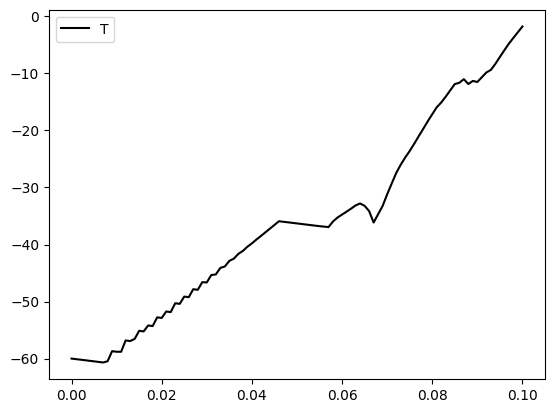

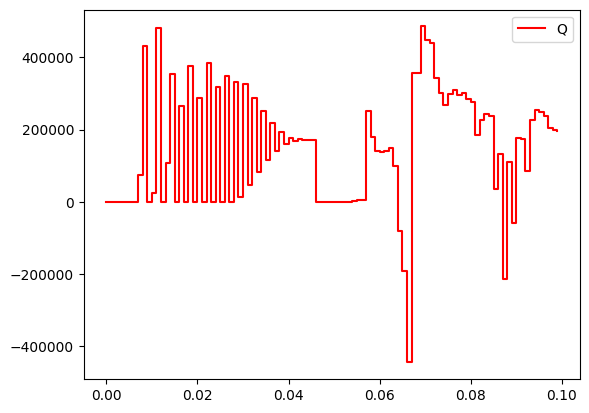

Total time required to execute the code = 66.770440 seconds 


In [6]:
#%%capture
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("Running Main Code Loop")
print("Number of times IPOPT will be called= ", NUM_MPC_ITERATION)
print("Number of Horizons[Sensor Data Readings] = ", controlTimeSteps)
print("Number of time steps per Horizon = ", integrationTimeSteps)
print("Number of State Variables = ", NUM_OUTPUTS)
print("Number of Control Inputs = ", NUM_U)
print("Size of u matrix = ", NUM_MPC_INPUTS)
print("Number of MPC Constraints = ", NUM_MPC_CONSTRAINTS)
for main_iteration in range(NUM_MPC_ITERATION):
    #####     Print Current Iteration Info     #####
    print("\n\n\n")
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print("Iteration #", main_iteration + 1)
    print("Current State Variable Values: CA = ", CA, ", T = ", T, "K")
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    #####        Set-up control inputs         #####
    if main_iteration == 0:
        uUnoptimized = np.array(
            [0] * NUM_MPC_INPUTS
        )  # which are u1 and u2 [Initialize blank array]
    else:
        uUnoptimized = u
        # Shift control inputs over 1 horizon(Last horizon is duplicated, but this is ok as we only sample and hold for 1 horizon)
        uUnoptimized[0:-NUM_U] = u[NUM_U:]
    for i in range(len(uUnoptimized)):
        uUnoptimized[i] = quant3(
            private_key.decrypt(public_key.encrypt(quant2(quant1(uUnoptimized[i]))))
        )
    print("The value of u before optimization is ", uUnoptimized)
    # Set up and solve optimization problem via IPOPT
    print("Solving IPOPT...")
    start_time_IPOPT = time.time()
    soln = minimize_ipopt(
        eval_f,
        jac=eval_grad_f,
        x0=uUnoptimized,
        bounds=bnds,
        constraints=cons,
        options={"maxiter": 500, "tol": 1e-4},
    )
    end_time_IPOPT = time.time()
    total_runtime_IPOPT = end_time_IPOPT - start_time_IPOPT
    print("Total time required to solve via IPOPT = %f seconds " % total_runtime_IPOPT)
    print("IPOPT Closed.")
    print(soln)

    # Print IPOPT Results
    u = soln.x
    for i in range(len(u)):
        u[i] = quant3(private_key.decrypt(public_key.encrypt(quant2(quant1(u[i])))))
    print("Optimized u values are:", u)

    # Define the initial values of the Control Variables
    CA0 = u.item(0)
    Q = u.item(1)
    u_record[:, [main_iteration]] = np.array([[CA0], [Q]])
    
    CA,T = model_makestep(CA,T,CA0,Q)
    CA = quant3(private_key.decrypt(public_key.encrypt(quant2(quant1(CA)))))
    T = quant3(private_key.decrypt(public_key.encrypt(quant2(quant1(T)))))
    x_real = np.array([[CA],[T]])
    x_record[:, [main_iteration + 1]] = x_real
    ##Sum the Cost Function over every HORIZON
    cost_record.append((-k0 * np.exp(E_over_R / (T + Ts)) * (CA + CAs) ** 2) * delta)
t = np.linspace(0, tFinal, int(tFinal / delta) + 1)

plt.plot(t, x_record[0, :], "k", label="CA")
plt.legend()
plt.show()

plt.step(t[:-1], u_record[0, :], "r", label="CA0", where="post")
plt.legend()
plt.show()

plt.plot(t, x_record[1, :], "k", label="T")
plt.legend()
plt.show()

plt.step(t[:-1], u_record[1, :], "r", label="Q", where="post")
plt.legend()
plt.show()

end_time = time.time()

total_runtime = end_time - start_time

print("Total time required to execute the code = %f seconds " % total_runtime)

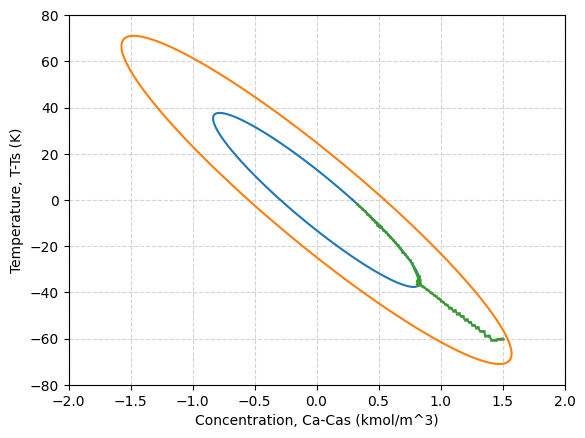

In [7]:
import os
import pickle
from math import cos, pi, sin

import numpy as np
from matplotlib import pyplot as plt

# plt.rcParams['text.usetex'] = True

A, B, C, F = 1060, 44, 0.52, -90
A2, B2, C2, F2 = 1060, 44, 0.52, -320
angle = 0.5 * np.arctan(B / (A - C))  # rotation angle
A_prime = A * (cos(angle)) ** 2 + B * cos(angle) * sin(angle) + C * (sin(angle)) ** 2
C_prime = A * (sin(angle)) ** 2 - B * cos(angle) * sin(angle) + C * (cos(angle)) ** 2
a = np.sqrt(-F / A_prime)  # radius on the x-axis
b = np.sqrt(-F / C_prime)  # radius on the y-axis
C_A_limit = np.sqrt(a**2 * (cos(angle)) ** 2 + b**2 * (sin(angle)) ** 2)
T_limit = np.sqrt(a**2 * (sin(angle)) ** 2 + b**2 * (cos(angle)) ** 2)

A_prime2 = (
    A2 * (cos(angle)) ** 2 + B2 * cos(angle) * sin(angle) + C2 * (sin(angle)) ** 2
)
C2_prime = (
    A2 * (sin(angle)) ** 2 - B2 * cos(angle) * sin(angle) + C2 * (cos(angle)) ** 2
)
a2 = np.sqrt(-F2 / A_prime2)  # radius on the x-axis
b2 = np.sqrt(-F2 / C2_prime)  # radius on the y-axis
C_A_limit = np.sqrt(a**2 * (cos(angle)) ** 2 + b**2 * (sin(angle)) ** 2)
T_limit = np.sqrt(a**2 * (sin(angle)) ** 2 + b**2 * (cos(angle)) ** 2)

u, v = 0, 0  # Unstable

t = np.linspace(0, 2 * pi, 100)
Ell = np.array(
    [a * np.cos(t), b * np.sin(t)]
)  # u,v removed to keep the same center location
R_rot = np.array(
    [[cos(angle), -sin(angle)], [sin(angle), cos(angle)]]
)  # 2-D rotation matrix

Ell_rot = np.zeros((2, Ell.shape[1]))
for i in range(Ell.shape[1]):
    Ell_rot[:, i] = np.dot(R_rot, Ell[:, i])


Ell2 = np.array(
    [a2 * np.cos(t), b2 * np.sin(t)]
)  # u,v removed to keep the same center location
R_rot2 = np.array(
    [[cos(angle), -sin(angle)], [sin(angle), cos(angle)]]
)  # 2-D rotation matrix

Ell_rot2 = np.zeros((2, Ell2.shape[1]))
for i in range(Ell2.shape[1]):
    Ell_rot2[:, i] = np.dot(R_rot2, Ell2[:, i])

plt.plot(u + Ell_rot[0, :], v + Ell_rot[1, :])
plt.plot(u + Ell_rot2[0, :], v + Ell_rot2[1, :])  # Rotated ellipse
for i in range(10):
    plt.plot(x_record[0, :], x_record[1, :], "o", alpha=0.2, markersize=1)
plt.plot(x_record[0], x_record[1])
plt.grid(color="lightgray", linestyle="--")
plt.xlim(-2, 2)
plt.ylim(-80, 80)
plt.xticks([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2])
plt.yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80])
plt.xlabel("Concentration, Ca-Cas (kmol/m^3)")
plt.ylabel("Temperature, T-Ts (K)")
plt.savefig("ellipse.pdf")

In [8]:
sum(-k0 * np.exp(E_over_R / (x_record[1] + Ts)) * (x_record[0] + CAs) ** 2) * delta

-0.5641856395043919

In [9]:
sum(u_record[0])

-239.03125

In [10]:
import time
import numpy as np
import math
CA=1.5
T=-40.2
CA0=0.4
Q=5.2e4

def model_makestep(CA,T,CA0,Q):
    for _ in range(100):  # Newtons Method x_1 ~ x_0 +hc*dx
            fun_1 = (
                Coeff1 * (CA0 - CA)
                - k0 * np.exp(E_over_R / (T + Ts)) * (CA + CAs) ** 2
                + k0 * np.exp(E_over_R / (Ts)) * (CAs) ** 2
            )
            fun_2 = (
                Coeff1 * (T0 - T0s - T)
                - Coeff2 * np.exp(E_over_R / (T + Ts)) * (CA + CAs) ** 2
                + Coeff2 * np.exp(E_over_R / (Ts)) * (CAs) ** 2
                + (Q) / Coeff3
            )
            CA = CA + hc * fun_1
            T = T + hc * fun_2
    return [CA,T]
def fun1(test):
    test -= k0 * np.exp(E_over_R / (T + Ts)) * (CA + CAs) ** 2
def fun2(test):
    test -= k0 * math.e**(E_over_R / (T + Ts)) * (CA + CAs) ** 2
def fun3(test):
    test -= k0 * math.exp(E_over_R / (T + Ts)) * (CA + CAs) ** 2
%timeit fun1(0.0)
%timeit fun2(0.0)
%timeit fun3(0.0)

1.03 μs ± 20.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
317 ns ± 1.43 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
285 ns ± 0.482 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [11]:
def test(a,b):
    return 2*a,2*b
a,b = test(1,2)
print(a)
print(b)

2
4


In [12]:
(-k0 * np.exp(E_over_R / (x_record[1] + Ts)) * (x_record[0] + CAs) ** 2)[990:]

array([], dtype=float64)

In [13]:
x_record[0][:50]

array([1.5       , 1.48915604, 1.47752234, 1.46588885, 1.45867614,
       1.44846989, 1.43843874, 1.42514883, 1.40929163, 1.39366192,
       1.380191  , 1.36251034, 1.34687913, 1.33319475, 1.31569055,
       1.30006081, 1.28726731, 1.27274833, 1.25731302, 1.24155124,
       1.2279671 , 1.21033978, 1.19481767, 1.17912894, 1.16438943,
       1.14790002, 1.13242166, 1.11668164, 1.10134612, 1.08545377,
       1.06982579, 1.05422164, 1.0385837 , 1.02297637, 1.00733888,
       0.99172888, 0.97609345, 0.96047908, 0.94484672, 0.92922814,
       0.91359779, 0.89797477, 0.88234628, 0.8667201 , 0.85109151,
       0.83546244, 0.81990959, 0.82024515, 0.81769669, 0.81432942])

In [14]:
x_record[1][:50]

array([-60.        , -60.09507778, -60.18968395, -60.28818695,
       -60.38654796, -60.48484661, -60.58313045, -60.68163398,
       -60.46436212, -58.70033468, -58.80038035, -58.8035013 ,
       -56.82071644, -56.922869  , -56.55569091, -55.12902052,
       -55.23280994, -54.19236907, -54.29607424, -52.76966628,
       -52.87416575, -51.74102893, -51.84772218, -50.29521102,
       -50.40195232, -49.12907146, -49.23416948, -47.83295474,
       -47.93692442, -46.60123207, -46.64738135, -45.34701333,
       -45.24710138, -44.10307894, -43.85066011, -42.87044325,
       -42.47262471, -41.63592131, -41.12437503, -40.39191052,
       -39.80189761, -39.129614  , -38.50363599, -37.85475307,
       -37.21582914, -36.5702166 , -35.9198175 , -36.01192095,
       -36.10639364, -36.20128727])